In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import pandas as pd

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

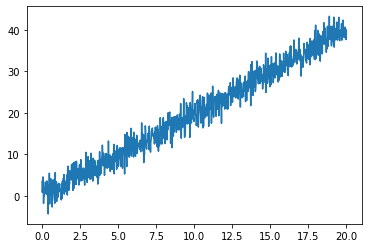

In [3]:
# generate linear time series data with some noise
n = 1000
x_max = 20
slope = 2
scale = 2

x_data = torch.from_numpy(np.linspace(0, x_max, n).reshape(-1, 1).astype(np.float32))
y_data = slope * x_data + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x_data, y_data)
plt.show()

### Split data set

In [4]:
def train_data(data, seq_length):
      
    data_x = []
    data_y = []
    
    # iterate through the array, one sequence at a time
    for n in range(0, data.shape[0]-seq_length):
        # The features
        data_x.append(data[n:n+seq_length])
        # The targets, shifted by one
        data_y.append(data[n+seq_length:n+seq_length+1])
        
    return data_x,data_y

In [5]:
x,y = train_data(y_data,40)
x = torch.cat(x,dim = -1)
x = x.reshape(960,40)
y = torch.cat(y,dim = 0)

In [7]:
x.shape

torch.Size([960, 40])

In [15]:
y.shape

torch.Size([960, 1])

In [9]:
lengths = [int(x.shape[0]*0.6), int(x.shape[0]*0.8)]
x_train, x_val, x_test = x[:lengths[0],], x[lengths[0]:lengths[1],:], x[lengths[1]:,:]
y_train, y_val, y_test = y[:lengths[0],], y[lengths[0]:lengths[1],:], y[lengths[1]:,:]


In [17]:
y_test.shape

torch.Size([192, 1])

# Define model that predicts quantiles

In [12]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, mode=None,method=None,significance=None, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            method=method,
            mode=mode,
            significance=significance,
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

# Train model to predict multiple quantiles

In [13]:
input_size = 1
output_size = 1
hidden_size = 16
optimizer = optim.Adam
optimizer_args = {"lr": 0.05}
max_epochs =100
batch_size = 10
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    method='conformal',
    mode = 'time_series',
    significance=0.1,
    optimizer_args=optimizer_args,
    scaler = None
    # scaler= StandardScaler()
)

In [14]:
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


torch.Size([345, 40])
torch.Size([345, 1])
Validation sanity check:   0%|                            | 0/1 [00:00<?, ?it/s]

/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: stack expects each tensor to be equal size, but got [231, 1] at entry 0 and [231, 40] at entry 1

In [48]:
y_pred = model.predict(x)
y_pred_conformal = model.conformal_predict(x)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

RuntimeError: input has inconsistent input_size: got 960 expected 1

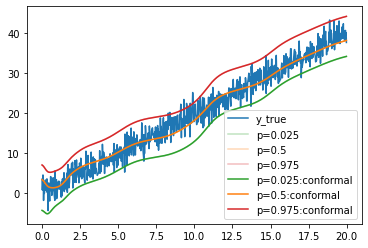

In [14]:
# plot x_train
y_pred = model.predict(x_train_sort)
y_pred_conformal = model.conformal_predict(x_train_sort)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_train_sort, y_train_sort, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_train_sort, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_train_sort, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

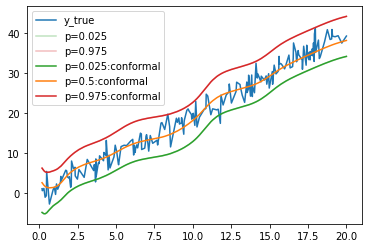

In [15]:
# plot x_test
y_pred = model.predict(x_test_sort)
y_pred_conformal = model.conformal_predict(x_test_sort)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_test_sort, y_test_sort, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    if i != 1:
        plt.plot(x_test_sort, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_test_sort, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

In [ ]:
y_pred_cal = model.predict(x_cal)
y_pred_cal_con = model.conformal_predict(x_cal)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_pred_cal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)
for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_pred_cal_con[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")

    
plt.legend()
plt.show()

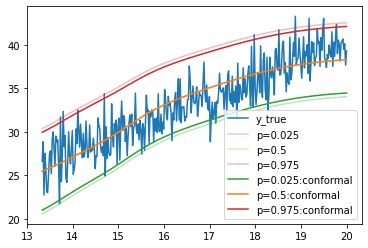

In [16]:
y_pred_test = model.predict(x_test)
y_pred_test_con = model.conformal_predict(x_test)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_test, y_test, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_test, y_pred_test[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)
for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_test, y_pred_test_con[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")

    
plt.legend()
plt.show()

In [ ]:
# idx = np.random.permutation(n)
# lengths = [int(n*0.6), int(n*0.8)]
# idx_train, idx_val, idx_test = idx[:lengths[0]], idx[lengths[0]:lengths[1]], idx[lengths[1]:]
# # idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])
# x_train = x[idx_train]
# y_train = y[idx_train]
# x_val = x[idx_val]
# y_val = y[idx_val]
# x_test = x[idx_test]
# y_test = y[idx_test]

In [ ]:
# # split to three sections
# window_size = n//3
# if n % 3 == 0:
#     # If an even split of data, then give each dataset n//3 entries
#     x_train = x[:window_size]
#     x_cal = x[window_size:window_size*2]
#     x_test = x[window_size*2:]
#     y_train = y[:window_size]
#     y_cal = y[window_size:window_size*2]
#     y_test = y[window_size*2:]
# elif n % 3 == 1:
#     # if there's 1 left, it automatically gets added to the test set
#     x_train = x[:window_size]
#     x_cal = x[window_size:window_size*2]
#     x_test = x[window_size*2:]
#     y_train = y[:window_size]
#     y_cal = y[window_size:window_size*2]
#     y_test = y[window_size*2:]
# elif n % 3 == 2:
#     # if there's 2 extra data points, add one to calibration, then other extra will go towards test
#     x_train = x[:window_size]
#     x_cal = x[window_size:window_size*2+1]
#     x_test = x[window_size*2:]
#     y_train = y[:window_size]
#     y_cal = y[window_size:window_size*2+1]
#     y_test = y[window_size*2:]

In [ ]:
# scaler = StandardScaler()


# # Scale the y data locally (ex. train scaled to train)
# y_train_scaled = scaler.fit_transform(y_train)
# y_cal_scaled = scaler.fit_transform(y_cal)
# y_test_scaled = scaler.fit_transform(y_test)

# # scaler.fit(y_train)
# # # Scale based on training set
# # y_train_scaled = scaler.transform(y_train)
# # y_cal_scaled = scaler.transform(y_cal)
# # y_test_scaled = scaler.transform(y_test)


# # Scale the x data locally (ex. train scaled to train)
# x_train_scaled = scaler.fit_transform(x_train)
# x_cal_scaled = scaler.fit_transform(x_cal)
# x_test_scaled = scaler.fit_transform(x_test)

# # Convert our scaled data into tensors of type float since that is what our torchTS model expects
# y_train = torch.tensor(y_train_scaled).float()
# y_cal = torch.tensor(y_cal_scaled).float()
# y_test = torch.tensor(y_test_scaled).float()

# x_train = torch.tensor(x_train_scaled).float()
# x_cal = torch.tensor(x_cal_scaled).float()
# x_test = torch.tensor(x_test_scaled).float()

In [ ]:
# # Split our training dataset into training and calibration sets randomly
# # and correct to maintain the timeseries convention of ascending x
# idx = np.random.permutation(n)
# n_half = int(np.floor(n/2))
# idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])

# # Perform split using our split indices
# x_train = x.numpy()[idx_train]
# x_cal = x.numpy()[idx_cal]

# y_train = y.numpy()[idx_train]
# y_cal = y.numpy()[idx_cal]

# plt.plot(torch.tensor(x_train), torch.tensor(y_train))
# plt.show()

# plt.plot(torch.tensor(x_cal), torch.tensor(y_cal))
# plt.show()

# x_train = torch.tensor(x_train)
# y_train = torch.tensor(y_train)
# x_cal = torch.tensor(x_cal)
# y_cal = torch.tensor(y_cal)

In [ ]:
# train model
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)
# inference
y_cal_preds = model.predict(x_cal)

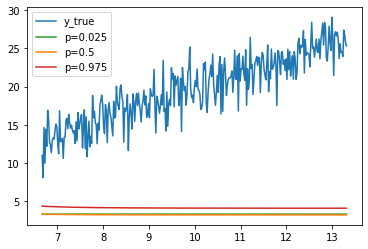

In [27]:
# n_quantiles = len(quantile)
# cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_index = [2, 1, 3]

# plt.plot(x, y, label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()
# plt.show()

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_cal_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

### Begin implementation of conformal prediction code

In [48]:
def quantile_err(prediction, y):
    """
    prediction: arr where first 3 columns are: lower quantile, middle quantile (50%), upper quantile in that order
    """
    y_lower = prediction[:, 0]
    y_upper = prediction[:, 2]
    # Calculate error on our predicted upper and lower quantiles
    # this will get us an array of negative values with the distance between the upper/lower quantile and the
    # 50% quantile
    error_low = y_lower - y
    error_high = y - y_upper
    # Make an array where each entry is the highest error when comparing the upper and lower bounds for that entry prediction 
    err = np.maximum(error_high, error_low)
    return err

In [49]:
# Find quantile error of our model
quantile_err(y_cal_preds, y_cal[:, 0])

tensor([-0.2157, -1.1425, -0.5725, -1.0078, -1.1158, -1.0800, -0.9064, -0.5258,
        -1.1967, -0.7940, -0.7273, -0.8658, -0.9925, -1.1612, -0.6423, -0.9134,
        -1.0952, -0.5000, -0.6431, -0.4628, -0.7690, -1.0903, -0.7029, -0.8152,
        -0.9817, -0.7399, -1.1772, -0.8447, -1.1123, -0.9609, -1.0965, -0.4948,
        -1.1143, -1.0927, -0.4527, -0.4197, -0.4318, -0.8455, -0.4288, -0.4211,
        -0.7094, -0.5409, -0.4197, -0.6056, -0.4322, -0.8403, -0.3695, -0.3885,
        -0.5792, -0.8438, -0.7676, -0.5641, -0.8771, -0.7292, -0.7396, -0.0866,
        -0.6764, -0.4695, -0.2241, -0.4501, -0.3191, -0.1381, -0.6174, -0.6701,
        -0.1606, -0.5815, -0.2052])

In [50]:
# store our quantile errors into variable named for calibration scores
cal_scores = quantile_err(y_cal_preds, y_cal[:, 0])

In [51]:
# Make a dictionary where our calibration scores (errors) are sorted in descending order
nc = {0: np.sort(cal_scores, 0)[::-1]}

In [52]:
# Specify significance we would like to see for our coverage when dealing with conformal prediction
significance = .1

In [53]:
# Sort calibration scores in ascending order? TODO make sure this is correct
# this is the apply_inverse portion of RegressorNC predict function
nc = np.sort(cal_scores,0)

index = int(np.ceil((1-significance) * (nc.shape[0] + 1))) - 1
# find largest error that gets us guaranteed coverage
index = min(max(index, 0), nc.shape[0] - 1)

err_dist = np.vstack([nc[index], nc[index]])

In [54]:
index

61

In [55]:
err_dist

array([[-0.22408685],
       [-0.22408685]], dtype=float32)

In [56]:
# store the predictions from our nonconformal quantile regressor
prediction = y_cal_preds

In [57]:
intervals = np.zeros((x_cal.shape[0],3))
# TODO ensure that we want to multiply our error distances by the size of our training set
err_dist = np.hstack([err_dist] * x_cal.shape[0])

In [58]:
prediction.shape

torch.Size([67, 3])

In [59]:
# CQR

# grab the first and last intervals predicted from our nonconformal quantile regressor in order to
# calculate our new intervals that fit our coverage requirements
intervals[:, 0] = prediction[:,0] - err_dist[0, :]
intervals[:, 1] = prediction[:,1]
intervals[:, 2] = prediction[:, -1] + err_dist[1,:]

conformal_intervals = intervals

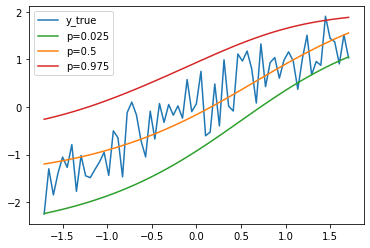

In [60]:
# n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(len(conformal_intervals)), color_index):
    plt.plot(x_cal, conformal_intervals[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# End of conformal implementation

# Add second response variable

In [26]:
# y_max = slope * x_max
# y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
# y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
# y = torch.hstack([y, y2])

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0])
# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1])
# plt.show()

# Train model to predict quantiles for two response variables

In [ ]:
# output_size = 2

# model = QuantileLSTM(
#     input_size,
#     output_size,
#     hidden_size,
#     optimizer,
#     quantile=quantile,
#     optimizer_args=optimizer_args,
# )

In [ ]:
# # train model
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# # inference
# y_preds = model.predict(x)

In [ ]:
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.show()